In [1]:
%cd drive/MyDrive/StyleEX/

/content/drive/MyDrive/StyleEX


In [2]:
%ls data/stylegan2/Dogs-Cats/

train/


In [3]:
%pip install labml
%pip install labml_helpers
%pip install labml_nn
%pip install lpips

In [4]:
#@title Architecture
import math
from typing import Tuple, Optional, List

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn


class MappingNetwork(nn.Module):
    """
    <a id="mapping_network"></a>
    ## Mapping Network
    ![Mapping Network](mapping_network.svg)
    This is an MLP with 8 linear layers.
    The mapping network maps the latent vector $z \in \mathcal{W}$
    to an intermediate latent space $w \in \mathcal{W}$.
    $\mathcal{W}$ space will be disentangled from the image space
    where the factors of variation become more linear.
    """

    def __init__(self, features: int, n_layers: int, outputs: int = 0):
        """
        * `features` is the number of features in $z$ and $w$
        * `n_layers` is the number of layers in the mapping network.
        """
        super().__init__()

        if outputs == 0:
          outputs = features

        # Create the MLP
        layers = []
        for i in range(n_layers-1):
            # [Equalized learning-rate linear layers](#equalized_linear)
            layers.append(EqualizedLinear(features, features))
            # Leaky Relu
            layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        # Change sizes in last layer
        layers.append(EqualizedLinear(features, outputs))
        layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        self.net = nn.Sequential(*layers)

    def forward(self, z: torch.Tensor):
        # Normalize $z$
        z = F.normalize(z, dim=1)
        # Map $z$ to $w$
        return self.net(z)


class Generator(nn.Module):
    """
    <a id="generator"></a>
    ## StyleGAN2 Generator
    ![Generator](style_gan2.svg)
    ---*$A$ denotes a linear layer.
    $B$ denotes a broadcast and scaling operation (noise is a single channel).
    [`toRGB`](#to_rgb) also has a style modulation which is not shown in the diagram to keep it simple.*---
    The generator starts with a learned constant.
    Then it has a series of blocks. The feature map resolution is doubled at each block
    Each block outputs an RGB image and they are scaled up and summed to get the final RGB image.
    """

    def __init__(self, log_resolution: int, d_latent: int, n_features: int = 32, max_features: int = 512):
        """
        * `log_resolution` is the $\log_2$ of image resolution
        * `d_latent` is the dimensionality of $w$
        * `n_features` number of features in the convolution layer at the highest resolution (final block)
        * `max_features` maximum number of features in any generator block
        """
        super().__init__()

        # Calculate the number of features for each block
        #
        # Something like `[512, 512, 256, 128, 64, 32]`
        features = [min(max_features, n_features * (2 ** i)) for i in range(log_resolution - 2, -1, -1)]
        # Number of generator blocks
        self.n_blocks = len(features)

        # Trainable $4 \times 4$ constant
        self.initial_constant = nn.Parameter(torch.randn((1, features[0], 4, 4)))

        # First style block for $4 \times 4$ resolution and layer to get RGB
        self.style_block = StyleBlock(d_latent, features[0], features[0])
        self.to_rgb = ToRGB(d_latent, features[0])

        # Generator blocks
        blocks = [GeneratorBlock(d_latent, features[i - 1], features[i]) for i in range(1, self.n_blocks)]
        self.blocks = nn.ModuleList(blocks)

        # $2 \times$ up sampling layer. The feature space is up sampled
        # at each block
        self.up_sample = UpSample()

    def forward(self, w: torch.Tensor, input_noise: List[Tuple[Optional[torch.Tensor], Optional[torch.Tensor]]]):
        """
        * `w` is $w$. In order to mix-styles (use different $w$ for different layers), we provide a separate
        $w$ for each [generator block](#generator_block). It has shape `[n_blocks, batch_size, d_latent]`.
        * `input_noise` is the noise for each block.
        It's a list of pairs of noise sensors because each block (except the initial) has two noise inputs
        after each convolution layer (see the diagram).
        """

        # Get batch size
        batch_size = w.shape[1]

        # Expand the learned constant to match batch size
        x = self.initial_constant.expand(batch_size, -1, -1, -1)

        # The first style block
        x = self.style_block(x, w[0], input_noise[0][1])
        # Get first rgb image
        rgb = self.to_rgb(x, w[0])

        # Evaluate rest of the blocks
        for i in range(1, self.n_blocks):
            # Up sample the feature map
            x = self.up_sample(x)
            # Run it through the [generator block](#generator_block)
            x, rgb_new = self.blocks[i - 1](x, w[i], input_noise[i])
            # Up sample the RGB image and add to the rgb from the block
            rgb = self.up_sample(rgb) + rgb_new

        # Return the final RGB image
        return rgb


class GeneratorBlock(nn.Module):
    """
    <a id="generator_block"></a>
    ### Generator Block
    ![Generator block](generator_block.svg)
    ---*$A$ denotes a linear layer.
    $B$ denotes a broadcast and scaling operation (noise is a single channel).
    [`toRGB`](#to_rgb) also has a style modulation which is not shown in the diagram to keep it simple.*---
    The generator block consists of two [style blocks](#style_block) ($3 \times 3$ convolutions with style modulation)
    and an RGB output.
    """

    def __init__(self, d_latent: int, in_features: int, out_features: int):
        """
        * `d_latent` is the dimensionality of $w$
        * `in_features` is the number of features in the input feature map
        * `out_features` is the number of features in the output feature map
        """
        super().__init__()

        # First [style block](#style_block) changes the feature map size to `out_features`
        self.style_block1 = StyleBlock(d_latent, in_features, out_features)
        # Second [style block](#style_block)
        self.style_block2 = StyleBlock(d_latent, out_features, out_features)

        # *toRGB* layer
        self.to_rgb = ToRGB(d_latent, out_features)

    def forward(self, x: torch.Tensor, w: torch.Tensor, noise: Tuple[Optional[torch.Tensor], Optional[torch.Tensor]]):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `w` is $w$ with shape `[batch_size, d_latent]`
        * `noise` is a tuple of two noise tensors of shape `[batch_size, 1, height, width]`
        """
        # First style block with first noise tensor.
        # The output is of shape `[batch_size, out_features, height, width]`
        x = self.style_block1(x, w, noise[0])
        # Second style block with second noise tensor.
        # The output is of shape `[batch_size, out_features, height, width]`
        x = self.style_block2(x, w, noise[1])

        # Get RGB image
        rgb = self.to_rgb(x, w)

        # Return feature map and rgb image
        return x, rgb


class StyleBlock(nn.Module):
    """
    <a id="style_block"></a>
    ### Style Block
    ![Style block](style_block.svg)
    ---*$A$ denotes a linear layer.
    $B$ denotes a broadcast and scaling operation (noise is single channel).*---
    Style block has a weight modulation convolution layer.
    """

    def __init__(self, d_latent: int, in_features: int, out_features: int):
        """
        * `d_latent` is the dimensionality of $w$
        * `in_features` is the number of features in the input feature map
        * `out_features` is the number of features in the output feature map
        """
        super().__init__()
        # Get style vector from $w$ (denoted by $A$ in the diagram) with
        # an [equalized learning-rate linear layer](#equalized_linear)
        self.to_style = EqualizedLinear(d_latent, in_features, bias=1.0)
        # Weight modulated convolution layer
        self.conv = Conv2dWeightModulate(in_features, out_features, kernel_size=3)
        # Noise scale
        self.scale_noise = nn.Parameter(torch.zeros(1))
        # Bias
        self.bias = nn.Parameter(torch.zeros(out_features))

        # Activation function
        self.activation = nn.LeakyReLU(0.2, True)

    def forward(self, x: torch.Tensor, w: torch.Tensor, noise: Optional[torch.Tensor]):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `w` is $w$ with shape `[batch_size, d_latent]`
        * `noise` is a tensor of shape `[batch_size, 1, height, width]`
        """
        # Get style vector $s$
        s = self.to_style(w)
        # Weight modulated convolution
        x = self.conv(x, s)
        # Scale and add noise
        if noise is not None:
            x = x + self.scale_noise[None, :, None, None] * noise
        # Add bias and evaluate activation function
        return self.activation(x + self.bias[None, :, None, None])


class ToRGB(nn.Module):
    """
    <a id="to_rgb"></a>
    ### To RGB
    ![To RGB](to_rgb.svg)
    ---*$A$ denotes a linear layer.*---
    Generates an RGB image from a feature map using $1 \times 1$ convolution.
    """

    def __init__(self, d_latent: int, features: int):
        """
        * `d_latent` is the dimensionality of $w$
        * `features` is the number of features in the feature map
        """
        super().__init__()
        # Get style vector from $w$ (denoted by $A$ in the diagram) with
        # an [equalized learning-rate linear layer](#equalized_linear)
        self.to_style = EqualizedLinear(d_latent, features, bias=1.0)

        # Weight modulated convolution layer without demodulation
        self.conv = Conv2dWeightModulate(features, 3, kernel_size=1, demodulate=False)
        # Bias
        self.bias = nn.Parameter(torch.zeros(3))
        # Activation function
        self.activation = nn.LeakyReLU(0.2, True)

    def forward(self, x: torch.Tensor, w: torch.Tensor):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `w` is $w$ with shape `[batch_size, d_latent]`
        """
        # Get style vector $s$
        style = self.to_style(w)
        # Weight modulated convolution
        x = self.conv(x, style)
        # Add bias and evaluate activation function
        return self.activation(x + self.bias[None, :, None, None])


class Conv2dWeightModulate(nn.Module):
    """
    ### Convolution with Weight Modulation and Demodulation
    This layer scales the convolution weights by the style vector and demodulates by normalizing it.
    """

    def __init__(self, in_features: int, out_features: int, kernel_size: int,
                 demodulate: float = True, eps: float = 1e-8):
        """
        * `in_features` is the number of features in the input feature map
        * `out_features` is the number of features in the output feature map
        * `kernel_size` is the size of the convolution kernel
        * `demodulate` is flag whether to normalize weights by its standard deviation
        * `eps` is the $\epsilon$ for normalizing
        """
        super().__init__()
        # Number of output features
        self.out_features = out_features
        # Whether to normalize weights
        self.demodulate = demodulate
        # Padding size
        self.padding = (kernel_size - 1) // 2

        # [Weights parameter with equalized learning rate](#equalized_weight)
        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])
        # $\epsilon$
        self.eps = eps

    def forward(self, x: torch.Tensor, s: torch.Tensor):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `s` is style based scaling tensor of shape `[batch_size, in_features]`
        """

        # Get batch size, height and width
        b, _, h, w = x.shape

        # Reshape the scales
        s = s[:, None, :, None, None]
        # Get [learning rate equalized weights](#equalized_weight)
        weights = self.weight()[None, :, :, :, :]
        # $$w`_{i,j,k} = s_i * w_{i,j,k}$$
        # where $i$ is the input channel, $j$ is the output channel, and $k$ is the kernel index.
        #
        # The result has shape `[batch_size, out_features, in_features, kernel_size, kernel_size]`
        weights = weights * s

        # Demodulate
        if self.demodulate:
            # $$\sigma_j = \sqrt{\sum_{i,k} (w'_{i, j, k})^2 + \epsilon}$$
            sigma_inv = torch.rsqrt((weights ** 2).sum(dim=(2, 3, 4), keepdim=True) + self.eps)
            # $$w''_{i,j,k} = \frac{w'_{i,j,k}}{\sqrt{\sum_{i,k} (w'_{i, j, k})^2 + \epsilon}}$$
            weights = weights * sigma_inv

        # Reshape `x`
        x = x.reshape(1, -1, h, w)

        # Reshape weights
        _, _, *ws = weights.shape
        weights = weights.reshape(b * self.out_features, *ws)

        # Use grouped convolution to efficiently calculate the convolution with sample wise kernel.
        # i.e. we have a different kernel (weights) for each sample in the batch
        x = F.conv2d(x, weights, padding=self.padding, groups=b)

        # Reshape `x` to `[batch_size, out_features, height, width]` and return
        return x.reshape(-1, self.out_features, h, w)

class Classifier(nn.Module):
    def __init__(self, PATH):
        super().__init__()

        self.model = load_classifier(PATH)
    def forward(self, x: torch.Tensor):
        return self.model(x)
        
class Discriminator(nn.Module):
    """
    <a id="discriminator"></a>
    ## StyleGAN 2 Discriminator
    ![Discriminator](style_gan2_disc.svg)
    Discriminator first transforms the image to a feature map of the same resolution and then
    runs it through a series of blocks with residual connections.
    The resolution is down-sampled by $2 \times$ at each block while doubling the
    number of features.
    """

    def __init__(self, log_resolution: int, n_features: int = 64, max_features: int = 512):
        """
        * `log_resolution` is the $\log_2$ of image resolution
        * `n_features` number of features in the convolution layer at the highest resolution (first block)
        * `max_features` maximum number of features in any generator block
        """
        super().__init__()

        # Layer to convert RGB image to a feature map with `n_features` number of features.
        self.from_rgb = nn.Sequential(
            EqualizedConv2d(3, n_features, 1),
            nn.LeakyReLU(0.2, True),
        )

        features = [min(max_features, n_features * (2 ** i)) for i in range(log_resolution - 1)]
        n_blocks = len(features) - 1
        blocks = [DiscriminatorBlock(features[i], features[i + 1]) for i in range(n_blocks)]
        self.blocks = nn.Sequential(*blocks)

        self.std_dev = MiniBatchStdDev()
        final_features = features[-1] + 1
        self.conv = EqualizedConv2d(final_features, final_features, 3)
        self.final = EqualizedLinear(2 * 2 * final_features, 1)

    def forward(self, x: torch.Tensor):

        x = x - 0.5
        x = self.from_rgb(x)
        x = self.blocks(x)

        x = self.std_dev(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        return self.final(x)

class Encoder(nn.Module):
    """
    <a id="discriminator"></a>
    ## StyleGAN 2 Discriminator
    ![Discriminator](style_gan2_disc.svg)
    Discriminator first transforms the image to a feature map of the same resolution and then
    runs it through a series of blocks with residual connections.
    The resolution is down-sampled by $2 \times$ at each block while doubling the
    number of features.
    """

    def __init__(self, log_resolution: int, d_latent: int, n_features: int = 64, max_features: int = 512):
        """
        * `log_resolution` is the $\log_2$ of image resolution
        * `n_features` number of features in the convolution layer at the highest resolution (first block)
        * `max_features` maximum number of features in any generator block
        """
        super().__init__()

        # Layer to convert RGB image to a feature map with `n_features` number of features.
        self.from_rgb = nn.Sequential(
            EqualizedConv2d(3, n_features, 1),
            nn.LeakyReLU(0.2, True),
        )

        features = [min(max_features, n_features * (2 ** i)) for i in range(log_resolution - 1)]
        n_blocks = len(features) - 1
        blocks = [DiscriminatorBlock(features[i], features[i + 1]) for i in range(n_blocks)]
        self.blocks = nn.Sequential(*blocks)

        self.std_dev = MiniBatchStdDev()
        final_features = features[-1] + 1
        self.conv = EqualizedConv2d(final_features, final_features, 3)
        self.final = EqualizedLinear(2 * 2 * final_features, d_latent)

    def forward(self, x: torch.Tensor):
        #print(x)
        x = x - 0.5
        x = self.from_rgb(x)
        x = self.blocks(x)

        x = self.std_dev(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)

        return self.final(x)


class DiscriminatorBlock(nn.Module):

    def __init__(self, in_features, out_features):
        super().__init__()
        self.residual = nn.Sequential(DownSample(),
                                      EqualizedConv2d(in_features, out_features, kernel_size=1))
        self.block = nn.Sequential(
            EqualizedConv2d(in_features, in_features, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, True),
            EqualizedConv2d(in_features, out_features, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, True),
        )
        self.down_sample = DownSample()
        self.scale = 1 / math.sqrt(2)

    def forward(self, x):
        residual = self.residual(x)
        x = self.block(x)
        x = self.down_sample(x)
        return (x + residual) * self.scale


class MiniBatchStdDev(nn.Module):

    def __init__(self, group_size: int = 4):
        super().__init__()
        self.group_size = group_size

    def forward(self, x: torch.Tensor):
        assert x.shape[0] % self.group_size == 0
        grouped = x.view(self.group_size, -1)
        std = torch.sqrt(grouped.var(dim=0) + 1e-8)
        std = std.mean().view(1, 1, 1, 1)
        b, _, h, w = x.shape
        std = std.expand(b, -1, h, w)
        return torch.cat([x, std], dim=1)


class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        # Smoothing layer
        self.smooth = Smooth()

    def forward(self, x: torch.Tensor):
        x = self.smooth(x)
        return F.interpolate(x, (x.shape[2] // 2, x.shape[3] // 2), mode='bilinear', align_corners=False)


class UpSample(nn.Module):

    def __init__(self):
        super().__init__()
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.smooth = Smooth()

    def forward(self, x: torch.Tensor):
        return self.smooth(self.up_sample(x))


class Smooth(nn.Module):
    def __init__(self):
        super().__init__()
        kernel = [[1, 2, 1],
                  [2, 4, 2],
                  [1, 2, 1]]
        kernel = torch.tensor([[kernel]], dtype=torch.float)
        kernel /= kernel.sum()
        self.kernel = nn.Parameter(kernel, requires_grad=False)
        self.pad = nn.ReplicationPad2d(1)

    def forward(self, x: torch.Tensor):
        b, c, h, w = x.shape
        x = x.view(-1, 1, h, w)
        x = self.pad(x)
        x = F.conv2d(x, self.kernel)
        return x.view(b, c, h, w)


class EqualizedLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: float = 0.):
        super().__init__()
        self.weight = EqualizedWeight([out_features, in_features])
        self.bias = nn.Parameter(torch.ones(out_features) * bias)

    def forward(self, x: torch.Tensor):
        return F.linear(x, self.weight(), bias=self.bias)


class EqualizedConv2d(nn.Module):
    def __init__(self, in_features: int, out_features: int,
                 kernel_size: int, padding: int = 0):
        super().__init__()
        self.padding = padding
        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])
        self.bias = nn.Parameter(torch.ones(out_features))

    def forward(self, x: torch.Tensor):
        return F.conv2d(x, self.weight(), bias=self.bias, padding=self.padding)


class EqualizedWeight(nn.Module):

    def __init__(self, shape: List[int]):
        super().__init__()
        self.c = 1 / math.sqrt(np.prod(shape[1:]))
        self.weight = nn.Parameter(torch.randn(shape))
    def forward(self):
        return self.weight * self.c


class GradientPenalty(nn.Module):
    def forward(self, x: torch.Tensor, d: torch.Tensor):
        batch_size = x.shape[0]
        gradients, *_ = torch.autograd.grad(outputs=d,
                                            inputs=x,
                                            grad_outputs=d.new_ones(d.shape),
                                            create_graph=True)
        
        gradients = gradients.reshape(batch_size, -1)
        norm = gradients.norm(2, dim=-1)
        return torch.mean(norm ** 2)


class PathLengthPenalty(nn.Module):
    def __init__(self, beta: float):
        super().__init__()
        self.beta = beta
        self.steps = nn.Parameter(torch.tensor(0.), requires_grad=False)
        self.exp_sum_a = nn.Parameter(torch.tensor(0.), requires_grad=False)

    def forward(self, w: torch.Tensor, x: torch.Tensor):
        device = x.device
        image_size = x.shape[2] * x.shape[3]
        y = torch.randn(x.shape, device=device)
        output = (x * y).sum() / math.sqrt(image_size)

        gradients, *_ = torch.autograd.grad(outputs=output,
                                            inputs=w,
                                            grad_outputs=torch.ones(output.shape, device=device),
                                            create_graph=True)
        
        norm = (gradients ** 2).sum(dim=2).mean(dim=1).sqrt()

        if self.steps > 0:
            a = self.exp_sum_a / (1 - self.beta ** self.steps)
            loss = torch.mean((norm - a) ** 2)
        else:
            loss = norm.new_tensor(0)

        mean = norm.mean().detach()
        self.exp_sum_a.mul_(self.beta).add_(mean, alpha=1 - self.beta)
        self.steps.add_(1.)
        return loss

In [5]:
#@title StylEx


class StylEx(nn.Module):
  def __init__(self,
               log_resolution = 5, # log image resolution
               n_z = 32, # dimensionality of the latent encoding
               n_c = 2, # dimensionality of conditional encoding (number of classes)
               n_s = 32, # dimensionality of the latent attribute layer
               color_channels = 3, # number of input channels
               classifier_path = './classifier.pt',
               device = None,
               style_mixing_prob = .9
               ):
    super().__init__()
    self.latent_dim = self.d_latent = n_z + n_c
    self.conditional_dim = n_c

    self.generator  = Generator(log_resolution, n_z+n_c, n_features=32)
    self.encoder = Encoder(log_resolution, d_latent=n_z)
    self.discriminator = Discriminator(log_resolution, n_features=32)
    self.random_mapping = MappingNetwork(features=n_z+n_c, n_layers=8)

    self.classifier = load_classifier(classifier_path)

    self.n_gen_blocks = self.generator.n_blocks
    self.device = device
    self.style_mixing_prob = style_mixing_prob

  # Generate noise for random generation
  def __noise__(self, batch_size: int, zeros:bool = False):
    noise = []
    resolution = 4
    if zeros:
      for i in range(self.n_gen_blocks):
        if i == 0:
          n1 = None
        else:
          n1 = torch.zeros(batch_size, 1, resolution, resolution, device=self.device)
        n2 = torch.zeros(batch_size, 1, resolution, resolution, device=self.device)
        noise.append((n1, n2))
        resolution *= 2
    else:
      for i in range(self.n_gen_blocks):
        if i == 0:
          n1 = None
        else:
          n1 = torch.randn(batch_size, 1, resolution, resolution, device=self.device)
        n2 = torch.randn(batch_size, 1, resolution, resolution, device=self.device)
        noise.append((n1, n2))
        resolution *= 2
    return noise

  # Sample random styles for training
  def __get_random__(self, batch_size: int):
    # Mix styles
    if torch.rand(()).item() < self.style_mixing_prob:
      # Random cross-over point
      cross_over_point = int(torch.rand(()).item() * self.n_gen_blocks)
      # Sample $z_1$ and $z_2$
      z2 = torch.randn(batch_size, self.latent_dim).to(self.device)
      z1 = torch.randn(batch_size, self.latent_dim).to(self.device)
      # Get $w_1$ and $w_2$
      w1 = self.random_mapping(z1)
      w2 = self.random_mapping(z2)
      # Expand $w_1$ and $w_2$ for the generator blocks and concatenate
      w1 = w1[None, :, :].expand(cross_over_point, -1, -1)
      w2 = w2[None, :, :].expand(self.n_gen_blocks - cross_over_point, -1, -1)
      return torch.cat((w1, w2), dim=0)

    # Without mixing
    else:
      # Sample $z$
      z = torch.randn(batch_size, self.latent_dim).to(self.device)
      # Use the mapping network trained for random sampling
      w = self.random_mapping(z)
      # Expand $w$ for the generator blocks
      return w[None, :, :].expand(self.n_gen_blocks, -1, -1)

  # Find the latent encoding vector appended with the classification vector
  def get_latent(self, x):
    z = self.encode(x)
    if self.conditional_dim > 0:
      c = self.classifier(x)
      w = torch.concat((z, c), dim=1)
    else:
      w = z
    #print('encoding', torch.abs(w).sum().item())
    return w

  # Classify the input image
  def classify(self, x):
    return F.log_softmax(self.classifier(x), dim = 1)

  # Return latent encoding of an image
  def encode(self, x):
    return self.encoder(x)

  # Transform latent, w, vector into the StyleSpace
  def get_attribute(self, w):
    print(error)
    return self.generator.StyleBlock(w)
  
  # Returns the reconstructed image and latent vector
  def reconstruct(self, x):
    w = self.get_latent(x)

    # Reconstructed
    if self.training:
      noise = self.__noise__(x.shape[0], zeros=False)
    else:
      noise = 0
    
    w = w[None, :, :].expand(self.n_gen_blocks, -1, -1)
    x_ = self.generator(w, noise)
    
    # Reconstructed latent space
    # z_ = self.encode(x_)
    # z_ = 0
    return x_, w

  def get_w(self, batch_size: int):
        """
        ### Sample $w$
        This samples $z$ randomly and get $w$ from the mapping network.
        We also apply style mixing sometimes where we generate two latent variables
        $z_1$ and $z_2$ and get corresponding $w_1$ and $w_2$.
        Then we randomly sample a cross-over point and apply $w_1$ to
        the generator blocks before the cross-over point and
        $w_2$ to the blocks after.
        """

        # Mix styles
        if torch.rand(()).item() < self.style_mixing_prob:
            # Random cross-over point
            cross_over_point = int(torch.rand(()).item() * self.n_gen_blocks)
            # Sample $z_1$ and $z_2$
            z2 = torch.randn(batch_size, self.d_latent).to(self.device)
            z1 = torch.randn(batch_size, self.d_latent).to(self.device)
            # Get $w_1$ and $w_2$
            w1 = self.random_mapping(z1)
            w2 = self.random_mapping(z2)
            # Expand $w_1$ and $w_2$ for the generator blocks and concatenate
            w1 = w1[None, :, :].expand(cross_over_point, -1, -1)
            w2 = w2[None, :, :].expand(self.n_gen_blocks - cross_over_point, -1, -1)
            return torch.cat((w1, w2), dim=0)
        # Without mixing
        else:
            # Sample $z$ and $z$
            z = torch.randn(batch_size, self.d_latent).to(self.device)
            # Get $w$ and $w$
            w = self.random_mapping(z)
            # Expand $w$ for the generator blocks
            return w[None, :, :].expand(self.n_gen_blocks, -1, -1)

  def get_noise(self, batch_size: int):
      """
      ### Generate noise
      This generates noise for each [generator block](index.html#generator_block)
      """
      # List to store noise
      noise = []
      # Noise resolution starts from $4$
      resolution = 4

      # Generate noise for each generator block
      for i in range(self.n_gen_blocks):
          # The first block has only one $3 \times 3$ convolution
          if i == 0:
              n1 = None
          # Generate noise to add after the first convolution layer
          else:
              n1 = torch.randn(batch_size, 1, resolution, resolution, device=self.device)
          # Generate noise to add after the second convolution layer
          n2 = torch.randn(batch_size, 1, resolution, resolution, device=self.device)

          # Add noise tensors to the list
          noise.append((n1, n2))

          # Next block has $2 \times$ resolution
          resolution *= 2

      # Return noise tensors
      return noise

  def generate_images(self, batch_size: int):
        # Get latent
        w = self.get_w(batch_size)
        # Get noise
        noise = self.get_noise(batch_size)

        images = self.generator(w, noise)

        # Return images and w
        return images, w
        

  def generate_style(self, s):
    return generator(s)


In [6]:
#@title Config
"""
---
title: StyleGAN 2 Model Training
summary: >
 An annotated PyTorch implementation of StyleGAN2 model training code.
---
# [StyleGAN 2](index.html) Model Training
This is the training code for [StyleGAN 2](index.html) model.
![Generated Images](generated_64.png)
---*These are $64 \times 64$ images generated after training for about 80K steps.*---
*Our implementation is a minimalistic StyleGAN 2 model training code.
Only single GPU training is supported to keep the implementation simple.
We managed to shrink it to keep it at less than 500 lines of code, including the training loop.*
*Without DDP (distributed data parallel) and multi-gpu training it will not be possible to train the model
for large resolutions (128+).
If you want training code with fp16 and DDP take a look at
[lucidrains/stylegan2-pytorch](https://github.com/lucidrains/stylegan2-pytorch).*
We trained this on [CelebA-HQ dataset](https://github.com/tkarras/progressive_growing_of_gans).
You can find the download instruction in this
[discussion on fast.ai](https://forums.fast.ai/t/download-celeba-hq-dataset/45873/3).
Save the images inside [`data/stylegan` folder](#dataset_path).
"""

import math
from pathlib import Path
from typing import Iterator, Tuple

import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import os
import lpips

from PIL import Image

from labml import tracker, lab, monit, experiment
from labml.configs import BaseConfigs
from labml_helpers.device import DeviceConfigs
from labml_helpers.train_valid import ModeState, hook_model_outputs
#from labml_nn.gan.stylegan import Discriminator, Generator, MappingNetwork, GradientPenalty, PathLengthPenalty
from labml_nn.gan.wasserstein import DiscriminatorLoss, GeneratorLoss
from labml_nn.utils import cycle_dataloader
from torch.utils.data import ConcatDataset


class Dataset(torch.utils.data.Dataset):
    """
    ## Dataset
    This loads the training dataset and resize it to the give image size.
    """

    def __init__(self, path: str, image_size: int):
        """
        * `path` path to the folder containing the images
        * `image_size` size of the image
        """
        super().__init__()

        # Get the paths of all `jpg` files
        self.paths = [p for p in Path(path).glob(f'**/*.jpg')]

        # Transformation
        self.transform = torchvision.transforms.Compose([
            # Resize the image
            torchvision.transforms.Resize(image_size),
            # Convert to PyTorch tensor
            torchvision.transforms.ToTensor(),
        ])

    def __len__(self):
        """Number of images"""
        return len(self.paths)

    def __getitem__(self, index):
        """Get the the `index`-th image"""
        path = self.paths[index]
        img = Image.open(path)
        return self.transform(img)
def get_mnist_data(train_dir, image_size, digit=8):

  data_transform = transforms.Compose([
    #transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((image_size,image_size)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
  ])

  train_files = os.listdir(train_dir)
  dataset = torchvision.datasets.MNIST(root='./data', 
                        train=True, 
                        download=True, 
                        transform=data_transform)
  idx = dataset.targets==digit
  dataset.targets = dataset.targets[idx]
  dataset.data = dataset.data[idx]
  return dataset
def get_mnist_2_digit_data(train_dir, image_size, digit_0=9, digit_1=8):

  data_transform = transforms.Compose([
    #transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((image_size,image_size)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
  ])
  train_files = os.listdir(train_dir)
  dataset = torchvision.datasets.MNIST(root='./data', 
                        train=True, 
                        download=True, 
                        transform=data_transform)
  idx_0 = dataset.targets==digit_0
  idx_1 = dataset.targets==digit_1
  
  data_0 = dataset.data[idx_0]
  targets_0 = torch.zeros(len(data_0))
  data_1 = dataset.data[idx_1]
  targets_1 = torch.zeros(len(data_1))
  dataset.data = torch.concat((data_0,data_1), dim = 0)
  dataset.targets = torch.concat((targets_0,targets_1), dim = 0)
  return dataset

def get_catdog_data(train_dir, image_size):

  class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
  data_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
  ])
  train_files = os.listdir(train_dir)
  cat_files = [tf for tf in train_files if 'cat' in tf]
  dog_files = [tf for tf in train_files if 'dog' in tf]

  cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
  dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

  catdogs = ConcatDataset([cats, dogs])
  return catdogs
class Configs(BaseConfigs):
    """
    ## Configurations
    """

    # Device to train the model on.
    # [`DeviceConfigs`](https://docs.labml.ai/api/helpers.html#labml_helpers.device.DeviceConfigs)
    #  picks up an available CUDA device or defaults to CPU.
    device: torch.device = DeviceConfigs()

    # [StyleGAN2 Discriminator](index.html#discriminator)
    discriminator: Discriminator
    # [StyleGAN2 Generator](index.html#generator)
    generator: Generator
    # [StylEx Encoder](index.html#encoder)
    encoder: Encoder
    # [StylEx Classifier](index.html#classifier)
    classifier: Classifier

    # [StylEx Model]
    model: StylEx
    
    # [Mapping network](index.html#mapping_network)
    mapping_network: MappingNetwork

    # Discriminator and generator loss functions.
    # We use [Wasserstein loss](../wasserstein/index.html)
    discriminator_loss: DiscriminatorLoss
    generator_loss: GeneratorLoss

    # Optimizers
    generator_optimizer: torch.optim.Adam
    discriminator_optimizer: torch.optim.Adam
    mapping_network_optimizer: torch.optim.Adam
    encoder_optimizer: torch.optim.Adam

    # [Gradient Penalty Regularization Loss](index.html#gradient_penalty)
    gradient_penalty = GradientPenalty()
    # Gradient penalty coefficient $\gamma$
    gradient_penalty_coefficient: float = 10.

    # [Path length penalty](index.html#path_length_penalty)
    path_length_penalty: PathLengthPenalty

    # Data loader
    loader: Iterator

    # Batch size
    batch_size: int = 32
    # Dimensionality of $z$ and $w$
    d_latent: int = 512
    # Height/width of the image
    image_size: int = 32
    # Number of layers in the mapping network
    mapping_network_layers: int = 8
    # Generator & Discriminator learning rate
    learning_rate: float = 1e-3
    # Mapping network learning rate ($100 \times$ lower than the others)
    mapping_network_learning_rate: float = 1e-5
    # Number of steps to accumulate gradients on. Use this to increase the effective batch size.
    gradient_accumulate_steps: int = 1
    # $\beta_1$ and $\beta_2$ for Adam optimizer
    adam_betas: Tuple[float, float] = (0.0, 0.99)
    # Probability of mixing styles
    style_mixing_prob: float = 0.9
    # Number of classes
    num_classes: int = 0

    # Total number of training steps
    training_steps: int = 150_000

    # Number of blocks in the generator (calculated based on image resolution)
    n_gen_blocks: int

    # ### Lazy regularization
    # Instead of calculating the regularization losses, the paper proposes lazy regularization
    # where the regularization terms are calculated once in a while.
    # This improves the training efficiency a lot.

    # The interval at which to compute gradient penalty
    lazy_gradient_penalty_interval: int = 4
    # Path length penalty calculation interval
    lazy_path_penalty_interval: int = 32
    # Skip calculating path length penalty during the initial phase of training
    lazy_path_penalty_after: int = 0

    # How often to log generated images
    log_generated_interval: int = 500
    # How often to save model checkpoints
    save_checkpoint_interval: int = 2_000

    # Training mode state for logging activations
    mode: ModeState
    # Whether to log model layer outputs
    log_layer_outputs: bool = False

    KL_loss: torch.nn = torch.nn.KLDivLoss(reduction='batchmean',log_target = True)
    lpips_loss: torch.nn
    L1_loss: torch.nn = torch.nn.L1Loss(reduction='mean')
    # [Reconstruction, Adversarial ,Classifier, Path Loss] loss weight
    loss_weights: list = [2, 1, 1, 1] 

    # <a id="dataset_path"></a>
    # We trained this on [CelebA-HQ dataset](https://github.com/tkarras/progressive_growing_of_gans).
    # You can find the download instruction in this
    # [discussion on fast.ai](https://forums.fast.ai/t/download-celeba-hq-dataset/45873/3).
    # Save the images inside `data/stylegan` folder.

    dataset_path: str = str('data/stylegan2/Dogs-Cats/train/')
    classifier_path: str = str('./mnist_classifier.pt')
    load_model: bool = False
    model_path: str = './StylEx.pt'

    def init(self):
        """
        ### Initialize
        """
        # Create dataset
        # dataset = get_catdog_data(self.dataset_path, self.image_size)
        # dataset = get_mnist_2_digit_data('./', self.image_size)
        dataset = get_mnist_data('./', self.image_size)
        #dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
        #                                download=True, transform=transform)
        

        # Create data loader
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, num_workers=2,
                                                 shuffle=True, drop_last=True, pin_memory=True)
        # Continuous [cyclic loader](../../utils.html#cycle_dataloader)
        self.loader = cycle_dataloader(dataloader)
        
        # $\log_2$ of image resolution
        log_resolution = int(math.log2(self.image_size))

        # Create discriminator and generator
        #self.discriminator = Discriminator(log_resolution).to(self.device)
        #self.generator = Generator(log_resolution, self.d_latent).to(self.device)
        #self.encoder = Encoder(log_resolution, self.d_latent).to(self.device)
        
        #self.classifier = Classifier(self.classifier_path).to(self.device)

        self.model = StylEx(log_resolution,
                            n_z = self.d_latent, 
                            n_s = self.d_latent,
                            n_c = self.num_classes,
                            classifier_path = self.classifier_path,
                            device = self.device
                            ).to(self.device)

        if self.load_model:
          self.model.load_state_dict(torch.load(self.model_path))
        # Get number of generator blocks for creating style and noise inputs
        self.n_gen_blocks = self.model.generator.n_blocks
        
        # Create mapping network
        #self.mapping_network = MappingNetwork(self.d_latent, self.mapping_network_layers).to(self.device)
        # Create path length penalty loss
        self.path_length_penalty = PathLengthPenalty(0.99).to(self.device)

        # Add model hooks to monitor layer outputs
        if self.log_layer_outputs:
            hook_model_outputs(self.mode, self.model.discriminator, 'discriminator')
            hook_model_outputs(self.mode, self.model.generator, 'generator')
            hook_model_outputs(self.mode, self.model.random_mapping, 'mapping_network')
            hook_model_outputs(self.mode, self.model.encoder, 'encoder')

        # Discriminator and generator losses
        self.discriminator_loss = DiscriminatorLoss().to(self.device)
        self.generator_loss = GeneratorLoss().to(self.device)

        # Create optimizers
        self.discriminator_optimizer = torch.optim.Adam(
            self.model.discriminator.parameters(),
            lr=self.learning_rate, betas=self.adam_betas
        )
        self.generator_optimizer = torch.optim.Adam(
            self.model.generator.parameters(),
            lr=self.learning_rate, betas=self.adam_betas
        )
        self.mapping_network_optimizer = torch.optim.Adam(
            self.model.random_mapping.parameters(),
            lr=self.mapping_network_learning_rate, betas=self.adam_betas
        )
        self.encoder_optimizer = torch.optim.Adam(
            self.model.encoder.parameters(),
            lr=self.learning_rate, betas=self.adam_betas
        )

        # Set tracker configurations
        tracker.set_image("generated", True)
        self.lpips_loss = lpips.LPIPS().to(self.device)

    def reconstruct_loss(self, x, x_, w = None):

        # Latent reconstruction loss
        if w == None:
          w = self.model.encode(x)
        w_ = self.model.encode(x_)
        L_w = self.L1_loss(w, w_)
        #print('L_z', L_w.item())

        # Feature reconstruction
        L_x = self.L1_loss(x, x_)
        #print('L_x', L_x.item())

        # Feature LPIPS loss
        L_LPIPS = self.lpips_loss(x, x_).mean()
        #print('L_LPIPS', L_LPIPS.item())

        L = .1*L_w + L_x + .1*L_LPIPS

        return L

    def classifier_loss(self, x, x_):
        L = self.KLLoss(self.model.classify(x_), self.model.classify(x))
        return L

    def generate_images(self, batch_size: int):
        """
        ### Generate images
        This generate images using the generator
        """

        
        return self.model.generate_images(batch_size)
    
    def step(self, idx: int):
        """
        ### Training Step
        """

        # Train the discriminator

        #print(idx)

        rand_switch = 0

        with monit.section('Discriminator'):
            # Reset gradients
            self.discriminator_optimizer.zero_grad()

            # Accumulate gradients for `gradient_accumulate_steps`
            for i in range(self.gradient_accumulate_steps):
                # Update `mode`. Set whether to log activation
                with self.mode.update(is_log_activations=(idx + 1) % self.log_generated_interval == 0):
                    

                    # Discriminator classification for generated images

                    # Get real images from the data loader
                    r_img, lbl = next(self.loader)
                    real_images = r_img.to(self.device)

                    # Encode and Reconstruct image
                    if rand_switch == 1:
                      # Sample random images
                      generated_images, _ = self.model.generate_images(self.batch_size)
                      fake_output = self.model.discriminator(generated_images.detach())
                    else:
                      generated_images, _ = self.model.reconstruct(real_images)
                      fake_output = self.model.discriminator(generated_images.detach())
                    
                    # We need to calculate gradients w.r.t. real images for gradient penalty
                    if (idx + 1) % self.lazy_gradient_penalty_interval == 0:
                        real_images.requires_grad_()

                    # Discriminator classification for real images
                    real_output = self.model.discriminator(real_images)

                    # Get discriminator loss
                    real_loss, fake_loss = self.discriminator_loss(real_output, fake_output)
                    disc_loss = real_loss + fake_loss

                    # Add gradient penalty
                    if (idx + 1) % self.lazy_gradient_penalty_interval == 0:
                        # Calculate and log gradient penalty
                        gp = self.gradient_penalty(real_images, real_output)
                        tracker.add('loss.gp', gp)
                        # Multiply by coefficient and add gradient penalty
                        disc_loss = disc_loss + 0.5 * self.gradient_penalty_coefficient * gp * self.lazy_gradient_penalty_interval

                    # Compute gradients
                    disc_loss.backward()

                    # Log discriminator loss
                    tracker.add('loss.discriminator_real', real_loss)
                    tracker.add('loss.discriminator_fake', fake_loss)

            if (idx + 1) % self.log_generated_interval == 0:
                # Log discriminator model parameters occasionally
                tracker.add('discriminator', self.model.discriminator)
            
            # Clip gradients for stabilization
            torch.nn.utils.clip_grad_norm_(self.model.discriminator.parameters(), max_norm=1.0)
            # Take optimizer step
            self.discriminator_optimizer.step()

        # Train the generator
        with monit.section('Generator'):
            # Reset gradients
            self.generator_optimizer.zero_grad()
            self.mapping_network_optimizer.zero_grad()
            self.encoder_optimizer.zero_grad()
            # self.affine_optimizer.zero_grad()

            # Accumulate gradients for `gradient_accumulate_steps`
            for i in range(self.gradient_accumulate_steps):
                # Get generator loss
                if rand_switch == 0:
                  # Reconstructed images
                  generated_images, _ = self.model.generate_images(self.batch_size)
                  generated_images = generated_images.detach()

                  recon_images, w = self.model.reconstruct(real_images)
                  gen_loss_rec = self.reconstruct_loss(real_images, 
                                                     recon_images)
                  recon_output = self.model.discriminator(recon_images)
                  gen_loss_adv = self.generator_loss(recon_output)
                  gen_loss_class = self.KL_loss(
                    self.model.classify(recon_images),
                    self.model.classify(real_images)
                    )
                  # Combine losses using config weight
                  gen_loss =  self.loss_weights[0]*gen_loss_rec + \
                              self.loss_weights[1]*gen_loss_adv + \
                              self.loss_weights[2]*gen_loss_class
                #Standard StyleGAN training
                else:
                  # Sample images from generator
                  generated_images, w = self.model.generate_images(self.batch_size)
                  # Discriminator classification for generated images
                  fake_output = self.model.discriminator(generated_images)
                  gen_loss = self.generator_loss(fake_output)
                                
                # Add path length penalty
                if idx > self.lazy_path_penalty_after and \
                  (idx + 1) % self.lazy_path_penalty_interval == 0:
                    # Calculate path length penalty
                    plp = self.path_length_penalty(w, recon_images)
                    # Ignore if `nan`
                    if not torch.isnan(plp):
                        tracker.add('loss.plp', plp)
                        gen_loss = gen_loss + self.loss_weights[3] * plp
                gen_loss = gen_loss.mean()
                # Calculate gradients
                gen_loss.backward()

                # Log generator loss
                if(rand_switch==0):
                  tracker.add('loss.classifier', gen_loss_class)
                  tracker.add('loss.reconstruction', gen_loss_rec)
                  tracker.add('loss.adversarial', gen_loss_adv)
                else:
                  tracker.add('loss.generator', gen_loss)
          

            if (idx + 1) % self.log_generated_interval == 0:
                # Log discriminator model parameters occasionally
                tracker.add('generator', self.model.generator)
                tracker.add('mapping_network', self.model.random_mapping)

            # Clip gradients for stabilization
            torch.nn.utils.clip_grad_norm_(self.model.generator.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(self.model.random_mapping.parameters(), max_norm=1.0)

            # Take optimizer step
            self.generator_optimizer.step()
            self.mapping_network_optimizer.step()
            self.encoder_optimizer.step()
            #print(generated_images.shape)
            #print(recon_images.shape)

        # Log generated images
        if (idx + 1) % self.log_generated_interval == 0:
            tracker.add('generated', torch.cat([generated_images[:3],recon_images[:3], real_images[:3]], dim=0))
        # Save model checkpoints
        if (idx + 1) % self.save_checkpoint_interval == 0:
            experiment.save_checkpoint()

        # Flush tracker
        tracker.save()


    def train(self):
        """
        ## Train model
        """

        # Loop for `training_steps`
        for i in monit.loop(self.training_steps):
            # Take a training step
            self.step(i)
            #
            if (i + 1) % self.log_generated_interval == 0:
                tracker.new_line()
            if i % 1000 == 0:
              torch.save(self.model.state_dict(), './StylEx.pt')
def load_classifier(path):
  device = 'cuda'
  model = torchvision.models.densenet121(pretrained=True)

  num_ftrs = model.classifier.in_features
  model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
    )
  model = model.to(device)
  model.load_state_dict(torch.load(path))
  return model

def main(load_model=False):
    """
    ### Train StyleGAN2
    """

    # Create an experiment
    experiment.create(name='stylegan2')
    # Create configurations object
    configs = Configs()

    # Set configurations and override some
    experiment.configs(configs, {
        'device.cuda_device': 0,
        'image_size': 32,
        'log_generated_interval': 200,
        'load_model' : load_model  
        })

    # Initialize
    configs.init()
    # Set models for saving and loading
    experiment.add_pytorch_models(mapping_network=configs.model.random_mapping,
                                  generator=configs.model.generator,
                                  discriminator=configs.model.discriminator)

    # Start the experiment
    with experiment.start():
        # Run the training loop
        configs.train()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth


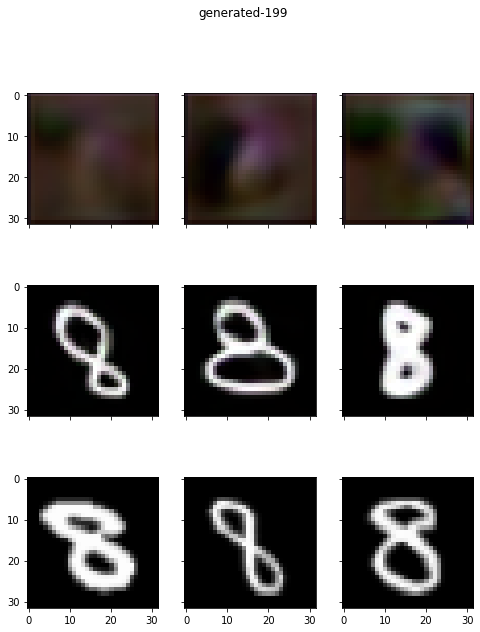

KeyboardInterrupt: ignored

In [7]:
main(load_model=True)

In [ ]:
experiment.create(name='stylegan2')
# Create configurations object
configs = Configs()

# Set configurations and override some
experiment.configs(configs, {
        'device.cuda_device': 0,
        'image_size': 32,
        'log_generated_interval': 200,
        'load_model' : True 
        })

# Initialize
configs.init()
configs.model.reconstruct()

In [ ]:
img = config.generate_images(32)[0].cpu().detach()[0]
plt.imshow(img)

In [ ]:
#@title Default title text

def step(self, idx: int):
        """
        ### Training Step
        """

        # Train the discriminator

        #print(idx)

        with monit.section('Discriminator'):
            # Reset gradients
            self.discriminator_optimizer.zero_grad()

            # Accumulate gradients for `gradient_accumulate_steps`
            for i in range(self.gradient_accumulate_steps):
                # Update `mode`. Set whether to log activation
                with self.mode.update(is_log_activations=(idx + 1) % self.log_generated_interval == 0):
                    # Sample images from generator
                    generated_images, _ = self.generate_images(self.batch_size)
                    # Discriminator classification for generated images
                    fake_output = self.model.discriminator(generated_images.detach())

                    # Get real images from the data loader
                    r_img, lbl = next(self.loader)
                    real_images = r_img.to(self.device)
                    # We need to calculate gradients w.r.t. real images for gradient penalty
                    if (idx + 1) % self.lazy_gradient_penalty_interval == 0:
                        real_images.requires_grad_()
                    # Discriminator classification for real images
                    real_output = self.model.discriminator(real_images)

                    # Get discriminator loss
                    real_loss, fake_loss = self.discriminator_loss(real_output, fake_output)
                    disc_loss = real_loss + fake_loss

                    # Add gradient penalty
                    if (idx + 1) % self.lazy_gradient_penalty_interval == 0:
                        # Calculate and log gradient penalty
                        gp = self.gradient_penalty(real_images, real_output)
                        tracker.add('loss.gp', gp)
                        # Multiply by coefficient and add gradient penalty
                        disc_loss = disc_loss + 0.5 * self.gradient_penalty_coefficient * gp * self.lazy_gradient_penalty_interval

                    # Compute gradients
                    disc_loss.backward()

                    # Log discriminator loss
                    tracker.add('loss.discriminator_real', real_loss)
                    tracker.add('loss.discriminator_fake', fake_loss)

            if (idx + 1) % self.log_generated_interval == 0:
                # Log discriminator model parameters occasionally
                tracker.add('discriminator', self.model.discriminator)
            
            # Clip gradients for stabilization
            torch.nn.utils.clip_grad_norm_(self.model.discriminator.parameters(), max_norm=1.0)
            # Take optimizer step
            self.discriminator_optimizer.step()

        # Train the generator
        with monit.section('Generator'):
            # Reset gradients
            self.generator_optimizer.zero_grad()
            self.mapping_network_optimizer.zero_grad()
            self.encoder_optimizer.zero_grad()
            self.affine_optimizer.zero_grad()

            # Accumulate gradients for `gradient_accumulate_steps`
            for i in range(self.gradient_accumulate_steps):
                # Sample images from generator
                generated_images, w = self.generate_images(self.batch_size)
                # Discriminator classification for generated images
                fake_output = self.model.discriminator(generated_images)
                # Reconstructed images
                recon_images = self.model.reconstruct(real_images)

                # Get generator loss
                gen_loss_rec = self.reconstruct_loss(real_images, 
                                                     recons_images)
                # Adversarial Loss
                gen_loss_adv = self.generator_loss(fake_output)
                # Classifier Loss
                gen_loss_class = self.KL_loss(
                    self.model.classify(real_images),
                    self.model.classify(recon_images)
                    )
                # Combine losses using config weight
                gen_loss =  self.loss_weights[0]*gen_loss_rec + \
                            self.loss_weights[1]*gen_loss_adv + \
                            self.loss_weights[2]*gen_loss_class

                # Add path length penalty
                if idx > self.lazy_path_penalty_after and \
                  (idx + 1) % self.lazy_path_penalty_interval == 0:
                    # Calculate path length penalty
                    plp = self.path_length_penalty(w, generated_images)
                    # Ignore if `nan`
                    if not torch.isnan(plp):
                        tracker.add('loss.plp', plp)
                        gen_loss = gen_loss + self.loss_weights[3] * plp

                # Calculate gradients
                gen_loss.backward()

                # Log generator loss
                tracker.add('loss.generator', gen_loss)

            if (idx + 1) % self.log_generated_interval == 0:
                # Log discriminator model parameters occasionally
                tracker.add('generator', self.model.generator)
                tracker.add('mapping_network', self.model.random_mapping)

            # Clip gradients for stabilization
            torch.nn.utils.clip_grad_norm_(self.model.generator.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(self.model.random_mapping.parameters(), max_norm=1.0)

            # Take optimizer step
            self.generator_optimizer.step()
            self.mapping_network_optimizer.step()
            self.encoder_optimizer.step()
            self.affine_optimizer.step()

        # Log generated images
        if (idx + 1) % self.log_generated_interval == 0:
            tracker.add('generated', torch.cat([generated_images[:6], real_images[:3]], dim=0))
        # Save model checkpoints
        if (idx + 1) % self.save_checkpoint_interval == 0:
            experiment.save_checkpoint()

        # Flush tracker
        tracker.save()
        #print(disc_loss + gen_loss)